# The Source Coding Theorem

## Information content of independent random variables

If $x$ and $y$ are independent, the following identities hold
$$h\left(x,y\right) = h\left(x\right) + h\left(y\right)$$
$$H\left(X,Y\right) = H\left(X\right) + H\left(Y\right)$$
I.e., entrop and the SHannon information content are additive for independent variables.

## Designing informative experiments

One important property of the entropy is the following: The entropy of an ensemble $X$ is biggest if all the outcomes have equal probabilitiy $p_i=1/|\mathcal{A}_X|$. In other words: The outcome of a random experiment is guaranteed to be most informative if the probability distribution over outcomes is uniform.

### Example: Customer support ticket categories

We want to get a better intuition of what this property means. Let us assume that a support team receives tickets in 4 categories:
* Billing
* Technical issue
* Account access
* Cancellation

If one category happens almost all the time, then each new ticket tells you little (low entropy). If all 4 categories are equally likely, each new ticket is more surprising/informative (high entropy).

Let us start by comparing the entropy of different examples of probability distributions:

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from entropy_lab.measures.entropy import compute_entropy

labels = ["Billing", "Tech", "Access", "Cancel"]

distributions = {
    "Very skewed": np.array([0.85, 0.10, 0.03, 0.02]),
    "Moderately skewed": np.array([0.55, 0.20, 0.15, 0.10]),
    "Almost balanced": np.array([0.30, 0.25, 0.25, 0.20]),
    "Uniform (max entropy)": np.array([0.25, 0.25, 0.25, 0.25])
}

for name, p in distributions.items():
    H = compute_entropy(p)
    print(f"{name:22s} -> H = {H:.4f} bits")

Very skewed            -> H = 0.7961 bits
Moderately skewed      -> H = 1.6815 bits
Almost balanced        -> H = 1.9855 bits
Uniform (max entropy)  -> H = 2.0000 bits


As expected, we can observe that:
1. Entropy increases as the distribution becomes more balanced.
2. The uniform case gives the highest entropy.
   
We can visualize this property by generating a plot that moves gradually from a peaked distribution to a uniform one:

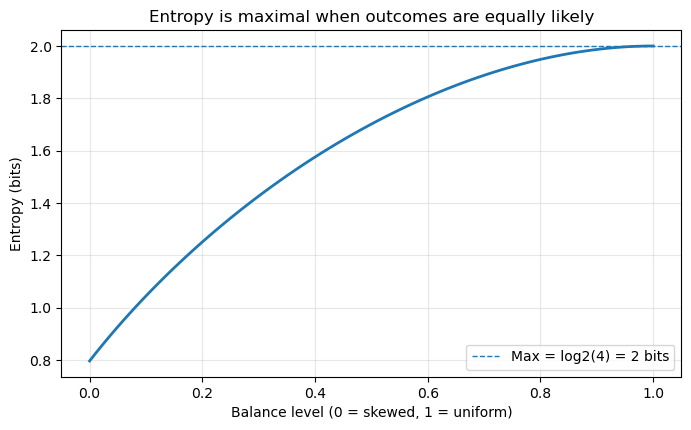

In [5]:
import numpy as np 
import matplotlib.pyplot as plt 

from entropy_lab.measures.entropy import compute_entropy

p_skewed = np.array([0.85, 0.10, 0.03, 0.02])
p_uniform = np.array([0.25, 0.25, 0.25, 0.25])

alphas = np.linspace(0, 1, 101)
entropies = []

for a in alphas:
    # Interpolate between skewed and uniform
    p = (1 - a) * p_skewed + a * p_uniform
    H = compute_entropy(p, base=2.0)
    entropies.append(H)

plt.figure(figsize=(8, 4.5))
plt.plot(alphas, entropies, linewidth=2)
plt.axhline(np.log2(4), linestyle="--", linewidth=1, label="Max = log2(4) = 2 bits")
plt.xlabel("Balance level (0 = skewed, 1 = uniform)")
plt.ylabel("Entropy (bits)")
plt.title("Entropy is maximal when outcomes are equally likely")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()